# Train Model: CNN

- Nama: Travis Zusa Zuve Saputra
- NIM: 22537141013
- Kelas: I.1

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

### Set Device and Seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
print(f"Using device: {device}")

Using device: cuda


### Data Transformation

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(64, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Loading Datasets and Calculating Class Weights

In [5]:
data_dir = '../data'
dataset = datasets.ImageFolder(data_dir, transform=train_transform)
class_counts = Counter([label for _, label in dataset])
num_classes = len(class_counts)
print(f"Class counts: {class_counts}")

Class counts: Counter({2: 106, 3: 106, 5: 102, 0: 86, 4: 77, 1: 75})


In [6]:
class_weights = torch.tensor([1.0 / class_counts[i] for i in range(num_classes)]).to(device)

### Split the Dataset into Train, Validation, and Test

In [7]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [8]:
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

### DataLoader

In [9]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Neural Network Model Definition

In [10]:
class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Model, Loss Function, Optimizer, dan Scheduler Initialization

In [11]:
model = ChessNet().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)

d:\Kuliah\Software\Visual Studio Code\Python\Semester_5\Praktik_Aplikasi_Web\Praktikum_09\chess-classification\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Validation Function

In [12]:
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    return val_loss / len(val_loader), accuracy

### Train Function, Plotting History Loss or Accuracy, and Confusion Matrix

In [13]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=50, model_path="../model/best-model-cnn.pth"):
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 5

    # Lists to store training history
    train_loss_history, val_loss_history = [], []
    train_acc_history, val_acc_history = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch+1}/{epochs}]")

        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            train_acc = 100 * correct_train / total_train
            progress_bar.set_postfix()

        val_loss, val_acc = validate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        # Record history
        train_loss_history.append(running_loss / len(train_loader))
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f"Model improved, saved as {model_path} with val_loss: {val_loss:.4f}, val_acc: {val_acc:.2f}%")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    # Plot loss and accuracy history
    epochs_range = list(range(1, len(train_loss_history) + 1))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))

    axes[0].plot(epochs_range, train_loss_history, label="Training")
    axes[0].plot(epochs_range, val_loss_history, label="Validation")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(epochs_range, train_acc_history, label="Training")
    axes[1].plot(epochs_range, val_acc_history, label="Validation")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_loader.dataset.dataset.classes)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix - Validation Set")
    plt.show()

### Train Function Calls

Epoch [1/50]: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]


Epoch [1/50], Train Loss: 3.3504, Train Acc: 17.91%, Val Loss: 1.8468, Val Acc: 25.45%
Model improved, saved as ../model/best-model.pth with val_loss: 1.8468, val_acc: 25.45%


Epoch [2/50]: 100%|██████████| 14/14 [00:04<00:00,  3.47it/s]


Epoch [2/50], Train Loss: 1.9867, Train Acc: 21.77%, Val Loss: 1.7650, Val Acc: 18.18%
Model improved, saved as ../model/best-model.pth with val_loss: 1.7650, val_acc: 18.18%


Epoch [3/50]: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s]


Epoch [3/50], Train Loss: 1.7418, Train Acc: 28.34%, Val Loss: 1.7411, Val Acc: 20.00%
Model improved, saved as ../model/best-model.pth with val_loss: 1.7411, val_acc: 20.00%


Epoch [4/50]: 100%|██████████| 14/14 [00:03<00:00,  3.80it/s]


Epoch [4/50], Train Loss: 1.7185, Train Acc: 25.85%, Val Loss: 1.7856, Val Acc: 21.82%


Epoch [5/50]: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]


Epoch [5/50], Train Loss: 1.6786, Train Acc: 30.61%, Val Loss: 1.6865, Val Acc: 27.27%
Model improved, saved as ../model/best-model.pth with val_loss: 1.6865, val_acc: 27.27%


Epoch [6/50]: 100%|██████████| 14/14 [00:03<00:00,  3.77it/s]


Epoch [6/50], Train Loss: 1.6649, Train Acc: 28.80%, Val Loss: 1.6755, Val Acc: 23.64%
Model improved, saved as ../model/best-model.pth with val_loss: 1.6755, val_acc: 23.64%


Epoch [7/50]: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]


Epoch [7/50], Train Loss: 1.6633, Train Acc: 29.71%, Val Loss: 1.6961, Val Acc: 18.18%


Epoch [8/50]: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Epoch [8/50], Train Loss: 1.6235, Train Acc: 30.16%, Val Loss: 1.6294, Val Acc: 27.27%
Model improved, saved as ../model/best-model.pth with val_loss: 1.6294, val_acc: 27.27%


Epoch [9/50]: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


Epoch [9/50], Train Loss: 1.5827, Train Acc: 30.39%, Val Loss: 1.6647, Val Acc: 29.09%


Epoch [10/50]: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Epoch [10/50], Train Loss: 1.5521, Train Acc: 35.60%, Val Loss: 1.5696, Val Acc: 32.73%
Model improved, saved as ../model/best-model.pth with val_loss: 1.5696, val_acc: 32.73%


Epoch [11/50]: 100%|██████████| 14/14 [00:04<00:00,  3.09it/s]


Epoch [11/50], Train Loss: 1.5438, Train Acc: 35.60%, Val Loss: 1.6077, Val Acc: 29.09%


Epoch [12/50]: 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]


Epoch [12/50], Train Loss: 1.4773, Train Acc: 38.10%, Val Loss: 1.5036, Val Acc: 45.45%
Model improved, saved as ../model/best-model.pth with val_loss: 1.5036, val_acc: 45.45%


Epoch [13/50]: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch [13/50], Train Loss: 1.4360, Train Acc: 39.23%, Val Loss: 1.5721, Val Acc: 30.91%


Epoch [14/50]: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch [14/50], Train Loss: 1.3883, Train Acc: 44.44%, Val Loss: 1.5569, Val Acc: 30.91%


Epoch [15/50]: 100%|██████████| 14/14 [00:04<00:00,  3.28it/s]


Epoch [15/50], Train Loss: 1.3862, Train Acc: 40.36%, Val Loss: 1.4816, Val Acc: 38.18%
Model improved, saved as ../model/best-model.pth with val_loss: 1.4816, val_acc: 38.18%


Epoch [16/50]: 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]


Epoch [16/50], Train Loss: 1.3008, Train Acc: 48.53%, Val Loss: 1.5139, Val Acc: 36.36%


Epoch [17/50]: 100%|██████████| 14/14 [00:04<00:00,  3.32it/s]


Epoch [17/50], Train Loss: 1.3004, Train Acc: 43.54%, Val Loss: 1.4853, Val Acc: 30.91%


Epoch [18/50]: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch [18/50], Train Loss: 1.2450, Train Acc: 50.34%, Val Loss: 1.4229, Val Acc: 38.18%
Model improved, saved as ../model/best-model.pth with val_loss: 1.4229, val_acc: 38.18%


Epoch [19/50]: 100%|██████████| 14/14 [00:04<00:00,  3.32it/s]


Epoch [19/50], Train Loss: 1.1678, Train Acc: 48.98%, Val Loss: 1.5329, Val Acc: 34.55%


Epoch [20/50]: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


Epoch [20/50], Train Loss: 1.1905, Train Acc: 51.02%, Val Loss: 1.4437, Val Acc: 36.36%


Epoch [21/50]: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


Epoch [21/50], Train Loss: 1.1739, Train Acc: 51.93%, Val Loss: 1.4714, Val Acc: 38.18%


Epoch [22/50]: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


Epoch [22/50], Train Loss: 1.1090, Train Acc: 55.56%, Val Loss: 1.3121, Val Acc: 43.64%
Model improved, saved as ../model/best-model.pth with val_loss: 1.3121, val_acc: 43.64%


Epoch [23/50]: 100%|██████████| 14/14 [00:04<00:00,  3.36it/s]


Epoch [23/50], Train Loss: 1.0884, Train Acc: 54.88%, Val Loss: 1.3281, Val Acc: 45.45%


Epoch [24/50]: 100%|██████████| 14/14 [00:04<00:00,  3.30it/s]


Epoch [24/50], Train Loss: 1.1041, Train Acc: 56.92%, Val Loss: 1.2918, Val Acc: 41.82%
Model improved, saved as ../model/best-model.pth with val_loss: 1.2918, val_acc: 41.82%


Epoch [25/50]: 100%|██████████| 14/14 [00:04<00:00,  3.08it/s]


Epoch [25/50], Train Loss: 1.0195, Train Acc: 59.41%, Val Loss: 1.2902, Val Acc: 47.27%
Model improved, saved as ../model/best-model.pth with val_loss: 1.2902, val_acc: 47.27%


Epoch [26/50]: 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]


Epoch [26/50], Train Loss: 0.9725, Train Acc: 61.90%, Val Loss: 1.2620, Val Acc: 47.27%
Model improved, saved as ../model/best-model.pth with val_loss: 1.2620, val_acc: 47.27%


Epoch [27/50]: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch [27/50], Train Loss: 0.9465, Train Acc: 63.49%, Val Loss: 1.2242, Val Acc: 45.45%
Model improved, saved as ../model/best-model.pth with val_loss: 1.2242, val_acc: 45.45%


Epoch [28/50]: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]


Epoch [28/50], Train Loss: 0.8992, Train Acc: 62.81%, Val Loss: 1.1739, Val Acc: 49.09%
Model improved, saved as ../model/best-model.pth with val_loss: 1.1739, val_acc: 49.09%


Epoch [29/50]: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch [29/50], Train Loss: 0.8709, Train Acc: 63.27%, Val Loss: 1.1442, Val Acc: 52.73%
Model improved, saved as ../model/best-model.pth with val_loss: 1.1442, val_acc: 52.73%


Epoch [30/50]: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


Epoch [30/50], Train Loss: 0.8638, Train Acc: 65.31%, Val Loss: 1.2283, Val Acc: 54.55%


Epoch [31/50]: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]


Epoch [31/50], Train Loss: 0.8117, Train Acc: 67.12%, Val Loss: 1.1718, Val Acc: 52.73%


Epoch [32/50]: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]


Epoch [32/50], Train Loss: 0.7914, Train Acc: 67.35%, Val Loss: 1.2217, Val Acc: 56.36%


Epoch [33/50]: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


Epoch [33/50], Train Loss: 0.6873, Train Acc: 73.02%, Val Loss: 1.2071, Val Acc: 56.36%


Epoch [34/50]: 100%|██████████| 14/14 [00:04<00:00,  3.29it/s]


Epoch [34/50], Train Loss: 0.6570, Train Acc: 71.43%, Val Loss: 1.0866, Val Acc: 65.45%
Model improved, saved as ../model/best-model.pth with val_loss: 1.0866, val_acc: 65.45%


Epoch [35/50]: 100%|██████████| 14/14 [00:04<00:00,  3.30it/s]


Epoch [35/50], Train Loss: 0.6627, Train Acc: 72.79%, Val Loss: 1.0790, Val Acc: 60.00%
Model improved, saved as ../model/best-model.pth with val_loss: 1.0790, val_acc: 60.00%


Epoch [36/50]: 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


Epoch [36/50], Train Loss: 0.6114, Train Acc: 77.32%, Val Loss: 1.0696, Val Acc: 61.82%
Model improved, saved as ../model/best-model.pth with val_loss: 1.0696, val_acc: 61.82%


Epoch [37/50]: 100%|██████████| 14/14 [00:04<00:00,  3.37it/s]


Epoch [37/50], Train Loss: 0.5531, Train Acc: 80.27%, Val Loss: 1.0242, Val Acc: 61.82%
Model improved, saved as ../model/best-model.pth with val_loss: 1.0242, val_acc: 61.82%


Epoch [38/50]: 100%|██████████| 14/14 [00:04<00:00,  3.37it/s]


Epoch [38/50], Train Loss: 0.5740, Train Acc: 76.19%, Val Loss: 1.0387, Val Acc: 61.82%


Epoch [39/50]: 100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


Epoch [39/50], Train Loss: 0.5460, Train Acc: 77.55%, Val Loss: 1.0746, Val Acc: 63.64%


Epoch [40/50]: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


Epoch [40/50], Train Loss: 0.5102, Train Acc: 82.31%, Val Loss: 1.0693, Val Acc: 60.00%


Epoch [41/50]: 100%|██████████| 14/14 [00:04<00:00,  3.35it/s]


Epoch [41/50], Train Loss: 0.5001, Train Acc: 79.37%, Val Loss: 1.0377, Val Acc: 61.82%


Epoch [42/50]: 100%|██████████| 14/14 [00:04<00:00,  3.30it/s]


Epoch [42/50], Train Loss: 0.5728, Train Acc: 78.23%, Val Loss: 1.0383, Val Acc: 60.00%
Early stopping triggered.


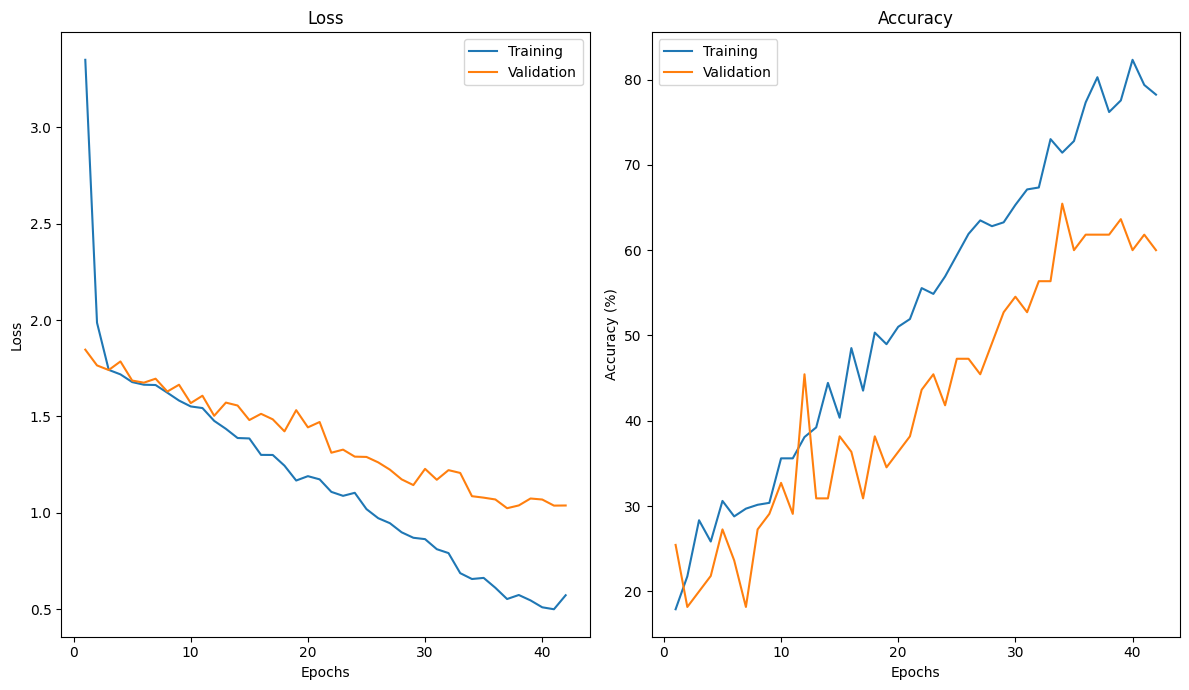

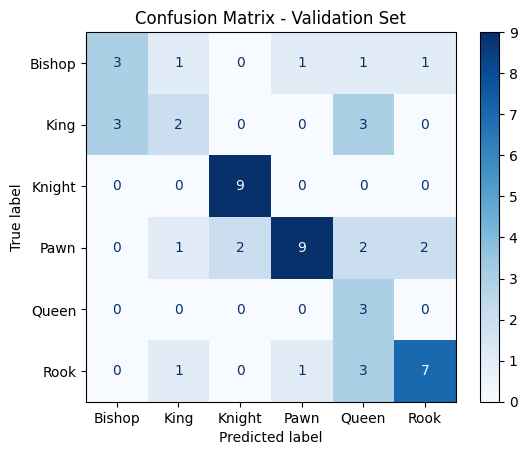

In [14]:
train(model, train_loader, val_loader, criterion, optimizer, scheduler, device)